***本项目是用来演示使用中文菜谱数据调优ChatGLM2-6B***

In [58]:
import os
print(os.path.abspath(os.curdir))

/root/rainbowliao


In [59]:
#安装必要的组件
!pip install scipy
#chatglm
!pip install transformers
!pip install sentencepiece

#finetune
!pip install -U accelerate
!pip install datasets
!pip install -U peft 
!pip install -U torchkeras 
!pip install bitsandbytes #==0.39.1  # 提供4bit量化支持，限制版本很重要

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [60]:
!pip show bitsandbytes

Name: bitsandbytes
Version: 0.40.2
Summary: k-bit optimizers and matrix multiplication routines.
Home-page: https://github.com/TimDettmers/bitsandbytes
Author: Tim Dettmers
Author-email: dettmers@cs.washington.edu
License: MIT
Location: /root/miniconda3/lib/python3.8/site-packages
Requires: 
Required-by: 


### 0. 测试ChatGLM原生的能力

In [61]:

from transformers import  AutoModel,AutoTokenizer, BitsAndBytesConfig
import torch
model_name = "THUDM/chatglm2-6b" # "../chatglm2-6b" #或者远程 “THUDM/chatglm2-6b”

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True, #QLoRA 设计的 Double Quantization
    bnb_4bit_quant_type='nf4', # QLoRA 设计的 Normal Float 4 量化数据类型
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name,
                                  quantization_config=bnb_config,
                                  trust_remote_code=True) #.half().cuda()

You are loading your model in 8bit or 4bit but no linear modules were found in your model. Please double check your model architecture, or submit an issue on github if you think this is a bug.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [62]:
# 测试当前模型的能力
response, his = model.chat(tokenizer, '宫保鸡丁', history=[])
print(response)

宫保鸡丁是一道以鸡肉为主料的川菜。以下是一种宫保鸡丁的常见做法:

所需材料:

- 鸡脯肉 250 克
- 干辣椒 3 根
- 姜 1 片
- 蒜 5 瓣
- 青红椒各 1 个
- 料酒 1 汤匙
- 生抽 1 汤匙
- 盐 1/2 茶匙
- 白胡椒粉 1/4 茶匙
- 糖 1/2 茶匙
- 鸡精 1/4 茶匙
- 生粉适量
- 葱花适量
- 食用油适量

做法步骤:

1. 鸡肉洗净,切成小丁,加入少许料酒、盐和生粉搅拌均匀腌制10分钟备用。

2. 干辣椒剪成2厘米长的段,姜、蒜切末备用。

3. 热锅凉油,加入腌制好的鸡肉丁煸炒至变色捞出备用。

4. 锅中留底油,加入干辣椒、姜蒜末煸炒出香味,加入青红椒继续煸炒。

5. 加入1汤匙生抽、1/2茶匙盐、1/4茶匙白胡椒粉、1/2茶匙糖和1/4茶匙鸡精翻炒均匀。

6. 加入炒好的鸡肉丁翻炒均匀,再加入葱花炒匀即可。

7. 装盘即可享用。

注意事项:

1. 鸡肉要切成小丁,这样更容易熟透。

2. 干辣椒可以先炒香,再切成小段。

3. 姜、蒜末和青红椒要炒出香味,这样才能让调料更好地渗透到鸡肉中。

4. 鸡精和白胡椒粉的用量要根据个人口味适量调整。


我们以自己收集的中文菜谱数据为例，介绍如何让大语言模型ChatGLM拥有新的技能。
通常来讲调优模型有以下几种方式：
1. 重新在新的数据集上训练模型，让模型具有相关的能力；
2. 使用预训练（pretrained）的模型为基础，在新的数据集上fine-tuning，使得模型具有新的技能；
3. 使用参数有效的调优策略（Parameter-Efficient Fine-Tuning，peft）给预训练模型打补丁，以补丁的形式让模型具备新的技能。

通常来说，对于1和2适用于小模型，一般是亿级以下参数量的模型。对于ChatGLM2-6b模型，其参数量为60亿，采用1和2的方式调优模型，必然会导致GPU的显存不够，造成OOM错误。因此，本示例采用3来调优ChatGLM2-6b模型。

### 1. 数据准备

#### 1.1 处理数据，提取必要的信息

数据总共包括136048条菜谱数据，数据类型如下：
    ```json
    {
      "id": "1",
      "title": "红烧鸡翅",
      "intro": "",
      "image": "http://i8.meishichina.com/attachment/recipe/200910/200910120907019.jpg@!p800",
      "steps": [
        {
          "index": 1,
          "image": "",
          "content": "鸡翅洗净抹干水分，加入腌料拌匀，腌制1小时"
        },
        {
          "index": 2,
          "image": "",
          "content": "牛腩切3厘米左右的块；土豆一半切1厘米小块另一半切3厘米左右的块；洋葱切碎，至于是切块还是切条切丝，大家随意啊；胡萝卜切的小一点，会入味，甜甜的。"
        },
        {
          "index": 3,
          "image": "",
          "content": "很疑惑"
        }
      ],
      "ingredients": {
        "鸡翅中": "8个",
        "姜（腌料）": "2片",
        "葱（腌料）": "2根",
        "盐（腌料）": "4克",
        "料酒（调料A）": "半汤勺",
        "酱油（调料A）": "1汤勺",
        "胡椒粉（调料A）": "少许",
        "蚝油（调料B）": "2汤勺",
        "糖（调料B）": "1茶勺",
        "麻油（调料B）": "少许"
      },
      "tags": [],
      "notice": "特点：色泽酱红，鲜香酥嫩。\n小提示：挑选鸡翅时，为了受热均匀，最好全部选用鸡翅中段。",
      "level": "普通",
      "craft": "烧",
      "duration": "一小时",
      "flavor": "原味"
    }
    '''

In [63]:
import json

def process_mstx(data_file):
    with open(data_file, 'r', encoding='utf-8-sig') as fd:
        meishi_json = json.load(fd)
    
    print(f"总共有{len(meishi_json)}个菜品")
    print(json.dumps(meishi_json[0], indent=2, ensure_ascii=False))
    
    data = []
    for food in meishi_json:
        # 食品名称
        food_name = food["title"]
        # 食材明细
        ingredient = ""
        for k,v in food["ingredients"].items():
            ingredient += f"{k} : {v} \n"
        # 制作步骤
        step = ""
        for st in food["steps"]:
            step += f"第{st['index']}步：{st['content']}"
            
        #制作方法
        craft = "" if food['craft'] is None else food['craft']
        duration = "" if food['duration'] is None else food['duration']
        method = craft + duration
        
        # 构建数据
        data.append({
            "id": food['id'],
            "菜品名称": food_name,
            "食材明细": ingredient,
            "制作步骤": step,
            "制作方法": method,
        })
    return data

In [64]:
data_file = "./mstx-中文菜谱.json"
meishi_data = process_mstx(data_file)
print(meishi_data[0])

processed_data_file = 'mstx-中文菜谱-processed.json'
with open(processed_data_file, 'w', encoding='utf-8') as fd:
        fd.write(json.dumps(meishi_data, indent=4, ensure_ascii=False))


总共有136048个菜品
{
  "id": "1",
  "title": "红烧鸡翅",
  "intro": "",
  "image": "http://i8.meishichina.com/attachment/recipe/200910/200910120907019.jpg@!p800",
  "steps": [
    {
      "index": 1,
      "image": "",
      "content": "鸡翅洗净抹干水分，加入腌料拌匀，腌制1小时"
    },
    {
      "index": 2,
      "image": "",
      "content": "牛腩切3厘米左右的块；土豆一半切1厘米小块另一半切3厘米左右的块；洋葱切碎，至于是切块还是切条切丝，大家随意啊；胡萝卜切的小一点，会入味，甜甜的。"
    },
    {
      "index": 3,
      "image": "",
      "content": "很疑惑"
    }
  ],
  "ingredients": {
    "鸡翅中": "8个",
    "姜（腌料）": "2片",
    "葱（腌料）": "2根",
    "盐（腌料）": "4克",
    "料酒（调料A）": "半汤勺",
    "酱油（调料A）": "1汤勺",
    "胡椒粉（调料A）": "少许",
    "蚝油（调料B）": "2汤勺",
    "糖（调料B）": "1茶勺",
    "麻油（调料B）": "少许"
  },
  "tags": [],
  "notice": "特点：色泽酱红，鲜香酥嫩。\n小提示：挑选鸡翅时，为了受热均匀，最好全部选用鸡翅中段。",
  "level": "普通",
  "craft": "烧",
  "duration": "一小时",
  "flavor": "原味"
}
{'id': '1', '菜品名称': '红烧鸡翅', '食材明细': '鸡翅中 : 8个 \n姜（腌料） : 2片 \n葱（腌料） : 2根 \n盐（腌料） : 4克 \n料酒（调料A） : 半汤勺 \n酱油（调料A） : 1汤勺 \n胡椒粉（调料A） : 少许 \n蚝油（调料B） : 2汤勺 \

#### 1.2 构建训练数据的prompt

在本示例中，我们构建三种类型的prompt，即：
1. 给定菜名，生成制作方法+食材+步骤
2. 给出制作方法+食材+步骤，生成菜名；
3. 判断给定的菜名和制作方法+食材+步骤是否匹配。

In [65]:
import json
import random
import datasets
import pandas as pd
random.seed(42)

In [66]:
def build_foodname_methods_prompt(data_file, prompt = ""):
    '''
    给菜名，生成制作方法+步骤+食材
    '''
    with open(data_file, "r", encoding='utf8') as f:
        caipu_json = json.load(f)
    print(f'总共有{len(caipu_json)}个菜品')

    data = []
    for caiming in caipu_json:
        # print(caiming['id'])
        # 菜品名称
        food_name = caiming["菜品名称"]

        # 食材明细
        ingredient = caiming["食材明细"]

        # 制作步骤
        step = caiming["制作步骤"]

        # 制作方法
        method = caiming["制作方法"]

        # 构建prompt
        prompt_item = {'prompt' : prompt + food_name, 'response':
            '\n' + '食材明细: \n' + ingredient + '\n' + "制作步骤: \n" +  step + '\n' +
            "制作方法: \n" + method + '\n'}
        data.append(prompt_item)
    return data

In [67]:
def build_methods_foodname_prompt(data_file, prompt=""):
    '''
    给食材+制作方法+步骤，生成菜名
    '''
    with open(data_file, "r", encoding='utf8') as f:
        caipu_json = json.load(f)
    print(f'总共有{len(caipu_json)}个菜品')

    data = []
    for caiming in caipu_json:
        # print(caiming['id'])
        # 菜品名称
        food_name = caiming["菜品名称"]

        # 食材明细
        ingredient = caiming["食材明细"]

        # 制作步骤
        step = caiming["制作步骤"]

        # 制作方法
        method = caiming["制作方法"]

        # 构建prompt
        prompt_item = {'prompt': prompt + '\n' + '食材明细: \n' + ingredient + '\n' + "制作步骤: \n" + step + '\n' +
            "制作方法: \n" + method + '\n', 'response': "以上步骤是菜品 (" + food_name + ") 的制作方法 \n"}
        data.append(prompt_item)
    return data

In [68]:
def build_foodname_match_methods_prompt(
        data_file,
        neg_sample_num=2,
        prompt="文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配"):
    '''
    给出 菜名 + 食材 + 制作方法 + 步骤， 给出判断是否匹配
    '''
    with open(data_file, "r", encoding='utf8') as f:
        caipu_json = json.load(f)
    total_food = len(caipu_json)
    print(f'总共有{total_food}个菜品')

    data = []
    for caiming in caipu_json:
        # print()
        id = caiming['id']
        # 菜品名称
        food_name = caiming["菜品名称"]

        # 食材明细
        ingredient = caiming["食材明细"]

        # 制作步骤
        step = caiming["制作步骤"]

        # 制作方法
        method = caiming["制作方法"]

        prompt1 = prompt + '\n' + f"烹制{food_name}的方式如下:\n" + '食材明细: \n' + ingredient + '\n' + "制作步骤: \n" + step + \
                 '\n' + "制作方法: \n" + method + '\n'
        prompt2 = prompt + '\n' + f"烹制{food_name}的方式如下:\n" + '\n' + "制作步骤: \n" + step + '食材明细: \n' + ingredient + \
                  '\n' + "制作方法: \n" + method + '\n'
        prompt3 = prompt + '\n' + f"烹制{food_name}的方式如下:\n" + '\n' + "制作步骤: \n" + step + \
                  '\n' + "制作方法: \n" + method + '食材明细: \n' + ingredient + '\n'
        prompt4 = prompt + '\n' + f"烹制{food_name}的方式如下:\n" + '食材明细: \n' + ingredient + '\n' + \
                  '\n' + "制作方法: \n" + method + "制作步骤: \n" + step + '\n'
        data.append({"prompt": prompt1, "response": "上述菜名与烹饪方式是匹配的"})
        data.append({"prompt": prompt2, "response": "上述菜名与烹饪方式是匹配的"})
        data.append({"prompt": prompt3, "response": "上述菜名与烹饪方式是匹配的"})
        data.append({"prompt": prompt4, "response": "上述菜名与烹饪方式是匹配的"})

        sample_num = 0
        while True:
            sample_id = random.randint(0, total_food-1)
            if sample_id == id:
                continue
            sample_num += 1
            if sample_num > neg_sample_num:
                break
            neg_caiming = caipu_json[sample_id]
            neg_food_name = neg_caiming["菜品名称"]
            neg_ingredient = neg_caiming["食材明细"]
            neg_step = neg_caiming["制作步骤"]
            neg_method = neg_caiming["制作方法"]

            prompt1 = prompt + '\n' + f"烹制{food_name}的方式如下:\n" + '食材明细: \n' + neg_ingredient + '\n' +\
                      "制作步骤: \n" + neg_step + '\n' + "制作方法: \n" + neg_method + '\n'
            prompt2 = prompt + '\n' + f"烹制{neg_food_name}的方式如下:\n" + '食材明细: \n' + ingredient + '\n' + "制作步骤: \n" + step + \
                      '\n' + "制作方法: \n" + method + '\n'
            data.append({"prompt": prompt1, "response": "上述菜名与烹饪方式是不匹配的"})
            data.append({"prompt": prompt2, "response": "上述菜名与烹饪方式是不匹配的"})

    return data

In [69]:
def split_and_comcate(data_file):
    '''
    划分训练集和测试集，按照各自数据的8：2划分
    '''
    mathch_data = build_foodname_match_methods_prompt(data_file)
    print(f'一共产生数据: {len(mathch_data)} 条')
    mathch_data = pd.DataFrame(mathch_data)
    mathch_data_ds = datasets.Dataset.from_pandas(mathch_data).train_test_split(test_size=0.2, shuffle=True, seed=42)

    food_data = build_foodname_methods_prompt(data_file)
    print(f'一共产生数据: {len(food_data)} 条')
    food_data = pd.DataFrame(food_data)
    food_data_ds = datasets.Dataset.from_pandas(food_data).train_test_split(test_size=0.2, shuffle=True, seed=42)

    method_data = build_methods_foodname_prompt(data_file)
    print(f'一共产生数据: {len(method_data)} 条')
    method_data = pd.DataFrame(method_data)
    method_data_ds = datasets.Dataset.from_pandas(method_data).train_test_split(test_size=0.2, shuffle=True, seed=42)

    train_data = pd.concat([mathch_data_ds['train'].to_pandas(), food_data_ds['train'].to_pandas(),
                               method_data_ds['train'].to_pandas()])
    test_data = pd.concat([mathch_data_ds['test'].to_pandas(), food_data_ds['test'].to_pandas(),
                               method_data_ds['test'].to_pandas()])
    return train_data, test_data

In [70]:
# 将数据按照相应的prompt构建，并划分训练数据和测试数据

processed_data_file = 'mstx-中文菜谱-processed.json'
train_data, test_data = split_and_comcate(processed_data_file)
print(train_data.shape)
print(test_data.shape)
print(train_data.head(10))
train_data.to_parquet('train_data.parquet')
test_data.to_parquet('test_data.parquet')

总共有136048个菜品
一共产生数据: 1088384 条
总共有136048个菜品
一共产生数据: 136048 条
总共有136048个菜品
一共产生数据: 136048 条
(1088383, 2)
(272097, 2)
                                              prompt       response
0  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制第一次做——简简单...  上述菜名与烹饪方式是匹配的
1  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制彩色饺子的方式如下...  上述菜名与烹饪方式是匹配的
2  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制百姓家的普通饭--...  上述菜名与烹饪方式是匹配的
3  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制豆角木耳粉丝鸡蛋馅...  上述菜名与烹饪方式是匹配的
4  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制黄金Q虾棒的方式如...  上述菜名与烹饪方式是匹配的
5  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制芝麻酱拌生菜的方式...  上述菜名与烹饪方式是匹配的
6  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制三鲜汤的方式如下:...  上述菜名与烹饪方式是匹配的
7  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制薄皮馅饼的方式如下...  上述菜名与烹饪方式是匹配的
8  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制简单的辅食的方式如...  上述菜名与烹饪方式是匹配的
9  文本分类任务：判断菜品与制作方式的匹配醒进行判断，分成匹配和不匹配\n烹制红薯包子的方式如下...  上述菜名与烹饪方式是匹配的


In [71]:
ds_train = datasets.Dataset.from_pandas(train_data)
ds_test = datasets.Dataset.from_pandas(test_data)

### 2. token编码

为了将文本数据喂入模型，需要将词转换为token。也就是把prompt转化成prompt_ids，把response转化成response_ids.

同时，我们还需要将prompt_ids和response_ids拼接到一起作为模型的input_ids。

这是为什么呢？

因为ChatGLM2基座模型是一个TransformerDecoder结构，是一个被预选练过的纯粹的语言模型(LLM，Large Lauguage Model)。

一个纯粹的语言模型，本质上只能做一件事情，那就是计算任意一段话像'人话'的概率。

我们将prompt和response拼接到一起作为input_ids， ChatGLM2 就可以判断这段对话像'人类对话'的概率。

在训练的时候我们使用梯度下降的方法来让ChatGLM2的判断更加准确。

训练完成之后，在预测的时候，我们就可以利用贪心搜索或者束搜索的方法按照最像"人类对话"的方式进行更合理的文本生成。

In [72]:
from tqdm import tqdm
import transformers

# model_name = "../chatglm2-6b" #chatglm2-6b模型保存路径
max_seq_length = 1024
skip_over_length = True

#tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
config = transformers.AutoConfig.from_pretrained(model_name, trust_remote_code=True, device_map='auto')

def preprocess(example):
    context = example["prompt"]
    target = example["response"]
    
    context_ids = tokenizer.encode(
            context, 
            max_length=max_seq_length,
            truncation=True)
    
    target_ids = tokenizer.encode(
        target,
        max_length=max_seq_length,
        truncation=True,
        add_special_tokens=False)
    
    input_ids = context_ids + target_ids + [config.eos_token_id]
    
    # -100标志位后面会在计算loss时会被忽略不贡献损失，我们集中优化target部分生成的loss
    labels = [-100]*len(context_ids)+ target_ids + [config.eos_token_id]
    
    return {"input_ids": input_ids,
            "labels": labels,
            "context_len": len(context_ids),
            'target_len':len(target_ids)+1}

In [73]:
ds_train_token = ds_train.map(preprocess).select_columns(['input_ids','labels', 'context_len','target_len'])
#len_ids = [len(example["input_ids"]) for example in ds_train_token]
#longest = max(len_ids)
#print(longest)
if skip_over_length:
    ds_train_token = ds_train_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)

Map:   0%|          | 0/1088383 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1088383 [00:00<?, ? examples/s]

In [74]:
#len_ids = [len(example["input_ids"]) for example in ds_train_token]
#longest = max(len_ids)
#print(longest)

In [75]:
ds_test_token = ds_test.map(preprocess).select_columns(['input_ids', 'labels','context_len','target_len'])
#len_ids = [len(example["input_ids"]) for example in ds_test_token]
#longest = max(len_ids)
#print(longest)
if skip_over_length:
    ds_val_token = ds_test_token.filter(
        lambda example: example["context_len"]<max_seq_length and example["target_len"]<max_seq_length)

Map:   0%|          | 0/272097 [00:00<?, ? examples/s]

Filter:   0%|          | 0/272097 [00:00<?, ? examples/s]

#### 2.1 构建训练数据管道

In [76]:
def data_collator(examples: list):
    len_ids = [len(example["input_ids"]) for example in examples]
    longest = max(len_ids) #之后按照batch中最长的input_ids进行padding
    
    input_ids = []
    labels_list = []
    
    for length, example in sorted(zip(len_ids, examples), key=lambda x: -x[0]):
        ids = example["input_ids"]
        labs = example["labels"]
        
        ids = ids + [tokenizer.pad_token_id] * (longest - length)
        labs = labs + [-100] * (longest - length)
        
        input_ids.append(torch.LongTensor(ids))
        labels_list.append(torch.LongTensor(labs))
          
    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)
    return {
        "input_ids": input_ids,
        "labels": labels,
    }

In [77]:
import torch 
dl_train = torch.utils.data.DataLoader(ds_train_token,num_workers=2,batch_size=8,
                                       pin_memory=True,shuffle=True, collate_fn = data_collator)
dl_test = torch.utils.data.DataLoader(ds_test_token,num_workers=2,batch_size=8,
                                    pin_memory=True,shuffle=True, collate_fn = data_collator)

In [78]:
for batch in dl_train:
    break 
batch

{'input_ids': tensor([[64790, 64792, 30910,  ..., 36336, 54530,     2],
         [64790, 64792, 30910,  ...,     0,     0,     0],
         [64790, 64792, 30910,  ...,     0,     0,     0],
         ...,
         [64790, 64792, 30910,  ...,     0,     0,     0],
         [64790, 64792, 30910,  ...,     0,     0,     0],
         [64790, 64792, 30910,  ...,     0,     0,     0]]),
 'labels': tensor([[ -100,  -100,  -100,  ..., 36336, 54530,     2],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         ...,
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100]])}

In [79]:
# dl_train.size = 300
# dl_test.size = 100

### 3. 构建模型

本示例使用QLoRA来调优ChatGLM2-6B模型

In [80]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
from transformers import AutoTokenizer, AutoModel, TrainingArguments, AutoConfig
import torch
import torch.nn as nn
from peft import get_peft_model, LoraConfig, TaskType

# model = AutoModel.from_pretrained("../chatglm2-6b",
#                                  load_in_8bit=False,  #是否导入int8量化模型
#                                  trust_remote_code=True)

model.supports_gradient_checkpointing = True  #节约cuda
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

In [82]:
# 预处理量化模型，以适配LoRA调优
from peft import prepare_model_for_kbit_training
model = prepare_model_for_kbit_training(model)

In [83]:
# 找出所有的全连接，为全连接层添加LoRA适配器
#!pip install scipy
import bitsandbytes as bnb

def find_all_linear_modules(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(name[0] if len(names) == 1 else names[-1])
            
    if "lm_head" in lora_module_names:
        lora_module_names.remove("lm_head")
    return list(lora_module_names)

lora_modules = find_all_linear_modules(model)
print(lora_modules)

[]


In [85]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, 
    inference_mode=False,
    r=8,
    lora_alpha=32, 
    lora_dropout=0.1,
    #target_modules=lora_modules
)

model = get_peft_model(model, peft_config)
model.is_parallelizable = True
model.model_parallel = True
model.print_trainable_parameters()

trainable params: 1,949,696 || all params: 6,245,533,696 || trainable%: 0.031217444255383614


### 4. 训练模型

此处我们使用torchkeras工具包来构建训练流程。

In [86]:
from torchkeras import KerasModel 
from accelerate import Accelerator 

In [87]:
class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
    
    def __call__(self, batch):
        
        #loss
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss

        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    self.net = self.net.from_pretrained(self.net,ckpt_path)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 

In [88]:
keras_model = KerasModel(model,loss_fn = None,optimizer=torch.optim.AdamW(model.parameters(),lr=2e-6))
ckpt_path = 'meishi_chatglm2_qlora'

<<<<<< ⚡️ cuda is used >>>>>>


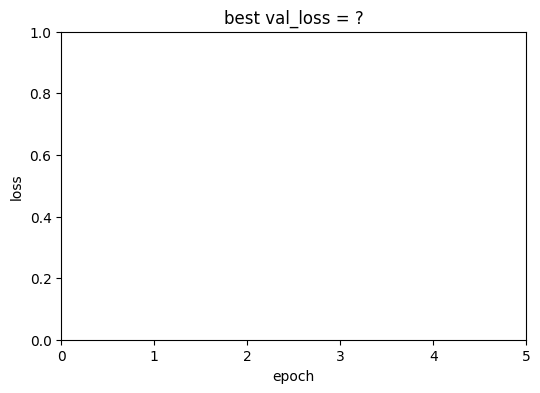

In [ ]:
keras_model.fit(train_data = dl_train,
                val_data = dl_test,
                epochs=5,
                patience=3, #for early stop
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                gradient_accumulation_steps=4
                #mixed_precision='fp16'
               )

### 5. 验证模型

根据已训练好的模型，来验证模型的效果。

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from transformers import  AutoModel,AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

model_name = "THUDM/chatglm2-6b" #"../chatglm2-6b" #或者远程 “THUDM/chatglm2-6b”
ckpt_path = 'meishi_chatglm2_qlora'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True, #QLoRA 设计的 Double Quantization
    bnb_4bit_quant_type='nf4', # QLoRA 设计的 Normal Float 4 量化数据类型
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
)

model = AutoModel.from_pretrained(model_name,
                                  load_in_8bit=False,
                                  trust_remote_code=True,
                                  device_map='auto')

model = PeftModel.from_pretrained(model, ckpt_path)
model = model.merge_and_unload() # 合并QLoRA的权重

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- tokenization_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- configuration_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- quantization.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- modeling_chatglm.py
- quantization.py
. Make sure to double-check they do not con

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# 测试新模型的能力
response, his = model.chat(tokenizer, '蕉牛奶西米捞', history=[])
print(response)

食材明细: 
香蕉 : 1根 
西米 : 适量 
牛奶 : 适量 

制作步骤: 
第1步：香蕉去皮切成小丁，牛奶中加少许盐，香蕉丁放入牛奶中拌匀。第2步：把香蕉牛奶倒入小碗里，放入冰箱冷冻至凝固。第3步：小碗里放入西米。第4步：加入少许水，盖盖子。第5步：放入冰箱冷冻至凝固。第6步：凝固后取出香蕉牛奶西米捞，加入少许糖。第7步：再加入香蕉丁。第8步：最后加入牛奶。第9步：拌匀即可。
制作方法: 
其他十分钟


In [4]:
response, his = model.chat(tokenizer, '辣拌脆黄瓜', history=[])
print(response)

食材明细: 
黄瓜 : 1根 
辣椒 : 2个 
蒜 : 1个 
盐 : 适量 
油 : 适量 
醋 : 适量 

制作步骤: 

制作方法: 
拌十分钟


In [8]:
integrate = "牛肉片 : 300克 \n青椒片 : 75克 \n洋葱片 : 50克 \n沙茶酱 : 75克 \n白糖 : 20克 \n白酱油 : 20克 \n淀粉 : 30克 \n蒜末 : 10克 \n花生酱 : 35克 \n味精 : 3克 \n熟猪油 : 适量 \n"
step = "第1步：牛肉片用白酱油抓匀，再加淀粉拌匀。第2步：将牛肉片加入沙茶酱、花生酱、白糖、蒜末、味精、再放入青椒片、洋葱片淋上熟猪油拌匀，用高档火打6分钟即可。"
method = "炒廿分钟"
prompt = "" + '\n' + '食材明细: \n' + integrate + '\n' + "制作步骤: \n" + step + '\n' + "制作方法: \n" + method + '\n'
response, his = model.chat(tokenizer, prompt, history=[])
print(response)

以上步骤是菜品【沙茶牛肉】的制作方法
